# Phase 4: Statistical Analysis

This notebook produces the figures and tables for the comparative analysis between Google Perspective and OpenAI Moderation outputs.

Sections:
1. Load dataset and setup
2. Correlation heatmap (mapped pairs)
3. Binary agreement: confusion matrices and metrics
4. Category-wise distributions and prevalence
5. Sensitivity curves (cross-system)
6. Disagreement patterns by segments
7. FP-like/FN-like characterization
8. Results summary and limitations



## Load dataset and setup

In [43]:
import json
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

DATASET_PATH = os.path.abspath(os.path.join('..','src','data','analysis_dataset.jsonl'))
assert os.path.exists(DATASET_PATH), f"Missing dataset: {DATASET_PATH}"

df = pd.read_json(DATASET_PATH, lines=True)
print(df.shape, df.columns.tolist()[:8], '...')


(6843, 22) ['post_id', 'thread_id', 'post_position', 'timestamp_iso', 'content_length', 'google_toxicity', 'google_severe_toxicity', 'google_threat'] ...


## Correlation heatmap (mapped pairs)

We pair Google attributes with OpenAI scores as follows:
- TOXICITY ↔ openai_harassment (and we will also explore broader composites)
- IDENTITY_ATTACK ↔ openai_hate
- THREAT ↔ openai_violence
- PROFANITY ↔ openai_sexual (approximate)
- SEVERE_TOXICITY ↔ openai_harassment (severity proxy)



                   google             openai  spearman_r
0         google_toxicity  openai_harassment    0.829809
1  google_identity_attack        openai_hate    0.871037
2           google_threat    openai_violence    0.640183
3        google_profanity      openai_sexual    0.425488
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/correlation_heatmap.png


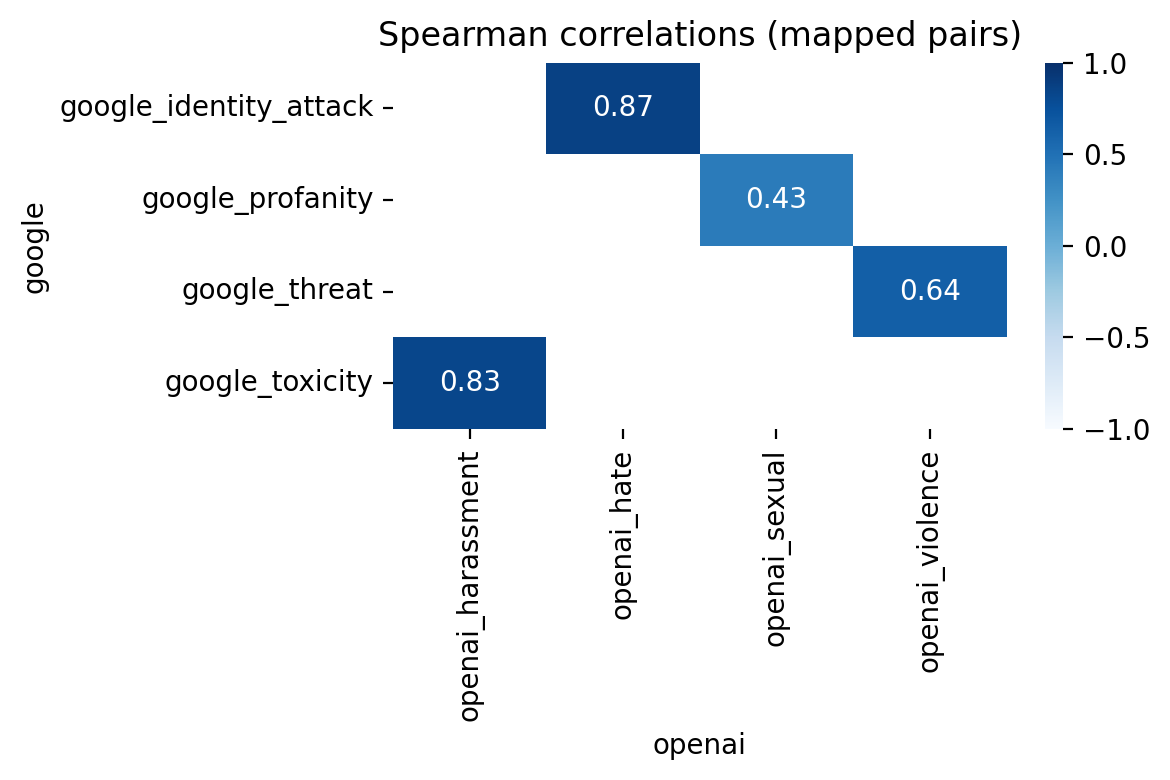

In [44]:
pairs = [
    ('google_toxicity','openai_harassment'),
    ('google_identity_attack','openai_hate'),
    ('google_threat','openai_violence'),
    ('google_profanity','openai_sexual'),
]

corrs = []
for g,o in pairs:
    x = df[g].astype(float)
    y = df[o].astype(float)
    corrs.append([g,o,x.corr(y, method='spearman')])

corr_df = pd.DataFrame(corrs, columns=['google','openai','spearman_r'])
print(corr_df)

# Heatmap-like display
mat = pd.pivot_table(corr_df, values='spearman_r', index='google', columns='openai')
fig = plt.figure(figsize=(6,4), dpi=200)
sns.heatmap(mat, annot=True, fmt='.2f', cmap='Blues', vmin=-1, vmax=1)
plt.title('Spearman correlations (mapped pairs)')
plt.tight_layout()

fig_path = os.path.abspath(os.path.join('..','reports','figures','correlation_heatmap.png'))
fig.savefig(fig_path, dpi=200, bbox_inches='tight')
print('Saved:', fig_path)


## Agreement/Disagreement Pattern Identification

This section quantifies where Google Perspective and OpenAI Moderation agree or disagree on toxicity judgments and summarizes patterns.

What we do here:
- Define positivity: Google positive if attribute ≥ threshold; OpenAI positive if `openai_flagged == True`.
- Compute and plot a confusion matrix for a key pairing (Google TOXICITY vs OpenAI flagged).
- Measure disagreement rates by segments (content length bins, thread position).
- Summarize FP-like/FN-like cases to characterize directional differences.

Run the cells below in order to reproduce all outputs for this question. Artifacts are saved under `reports/figures/` and `reports/metrics/`.


### A. Confusion matrix (Google TOXICITY vs OpenAI flagged)


[[3838 2431]
 [  18  556]]
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/cm_toxicity_vs_openai_flagged.png


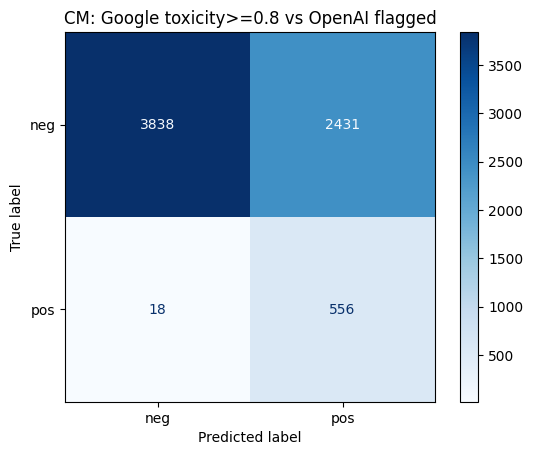

In [60]:
## Example confusion matrix for toxicity vs openai_flagged
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Thresholds
G_THR = 0.8
true_labels = (df['google_toxicity'] >= G_THR).astype(int)
pred_labels = df['openai_flagged'].astype(int)
cm = confusion_matrix(true_labels, pred_labels, labels=[0,1])
print(cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['neg','pos'])
disp.plot(values_format='d', cmap='Blues')
plt.title(f'CM: Google toxicity>={G_THR} vs OpenAI flagged')
fig_path = os.path.abspath(os.path.join('..','reports','figures','cm_toxicity_vs_openai_flagged.png'))
plt.savefig(fig_path, dpi=200, bbox_inches='tight')
print('Saved:', fig_path)


#### Explanation: Confusion matrix
- What it shows: Agreement (diagonal) vs disagreement (off-diagonal) between Google toxicity≥threshold and OpenAI flagged.
- How to read: 
  - Top-left (TN): both say not toxic.
  - Bottom-right (TP): both say toxic.
  - Top-right (FP for OpenAI vs Google): OpenAI flagged, Google below threshold.
  - Bottom-left (FN for OpenAI vs Google): Google ≥ threshold, OpenAI not flagged.
- Why it matters: Reveals who is stricter/looser at the chosen threshold and where mismatches concentrate.
- Caveat: Threshold (e.g., 0.8) affects counts; adjust to test robustness in `G_THR`.


### B. Disagreement rates by segments (content length, thread position)


#### Explanation: Disagreement by segments
- What it shows: How often the systems disagree within each segment (length bins, thread position).
- How to read: Taller bar = higher mismatch rate in that segment.
- Why it matters: Identifies contexts (e.g., very short posts or early thread replies) where divergence is higher.
- Caveat: Segment definitions (bin edges) can influence the pattern; see `disagreements_summary.json` for exact binning.


Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/disagreement_by_length.png
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/disagreement_by_position.png


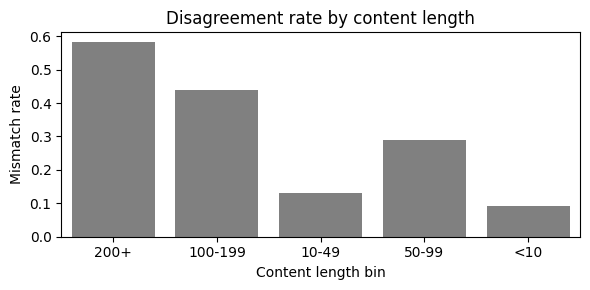

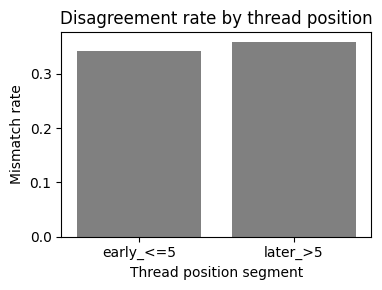

In [61]:
import json
DIS_PATH = os.path.abspath(os.path.join('..','reports','metrics','disagreements_summary.json'))
with open(DIS_PATH,'r') as f:
    dis = json.load(f)

# Length bins bar plot
by_len = dis['by_content_length']
len_bins = list(by_len.keys())
len_rates = [by_len[k]['mismatch_rate'] for k in len_bins]
plt.figure(figsize=(6,3))
sns.barplot(x=len_bins, y=len_rates, color='gray')
plt.ylabel('Mismatch rate')
plt.xlabel('Content length bin')
plt.title('Disagreement rate by content length')
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','disagreement_by_length.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)

# Early vs later bar plot
by_pos = dis['by_post_position']
pos_keys = list(by_pos.keys())
pos_rates = [by_pos[k]['mismatch_rate'] for k in pos_keys]
plt.figure(figsize=(4,3))
sns.barplot(x=pos_keys, y=pos_rates, color='gray')
plt.ylabel('Mismatch rate')
plt.xlabel('Thread position segment')
plt.title('Disagreement rate by thread position')
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','disagreement_by_position.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)


#### Explanation: FP-like / FN-like summaries
- What it shows: Typical characteristics (e.g., median lengths, scores) of cases where one system flags and the other does not.
- How to read: `openai_relative_to_google.fp_like` => OpenAI flagged but Google lower scores; `fn_like` => Google high score but OpenAI not flagged.
- Why it matters: Directional insight (stricter vs looser) and which content types drive mismatches.
- Caveat: These are summaries, not full statistical tests; use them to guide further inspection.


### C. FP-like / FN-like characterization (directional)


In [62]:
import json
from pprint import pprint
FPFN_PATH = os.path.abspath(os.path.join('..','reports','metrics','fp_fn_summary.json'))
with open(FPFN_PATH,'r') as f:
    fpfn = json.load(f)

print('OpenAI relative to Google (fn-like, fp-like):')
pprint(fpfn['openai_relative_to_google'])
print('\nGoogle relative to OpenAI (fn-like, fp-like):')
pprint(fpfn['google_relative_to_openai'])


OpenAI relative to Google (fn-like, fp-like):
{'fn_like': {'median_content_length': 51.5,
             'median_google_toxicity': 0.927816,
             'median_openai_hate': 0.010794745797220623,
             'n': 2},
 'fp_like': {'median_content_length': 140.0,
             'median_google_toxicity': 0.3722269,
             'median_openai_hate': 0.18167529479523412,
             'n': 1192}}

Google relative to OpenAI (fn-like, fp-like):
{'fn_like': {'median_content_length': 318.5,
             'median_google_toxicity': 0.405629335,
             'median_openai_hate': 0.9920228555877624,
             'n': 6},
 'fp_like': {'median_content_length': 98.0,
             'median_google_toxicity': 0.85850734,
             'median_openai_hate': 0.008427785733444715,
             'n': 173}}


Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/google_distributions.png


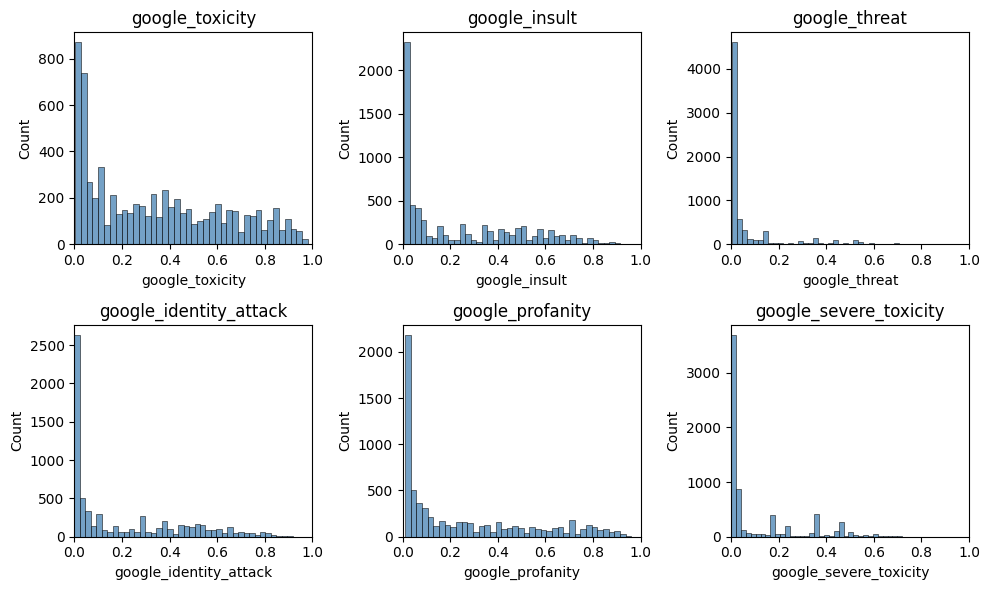

In [63]:
## Distributions: Google attributes
attrs = ['google_toxicity','google_insult','google_threat','google_identity_attack','google_profanity','google_severe_toxicity']
fig, axes = plt.subplots(2,3, figsize=(10,6))
for ax, col in zip(axes.flat, attrs):
    sns.histplot(df[col], bins=40, kde=False, ax=ax, color='steelblue')
    ax.set_title(col)
    ax.set_xlim(0,1)
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','google_distributions.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)


#### Explanation: Google category score distributions
- What it shows: The shape (skew, tails) of each Google category’s score distribution on the cohort.
- How to read: Mass near 0 implies rarity/low intensity; heavier right tails imply more frequent/stronger signals.
- Use with metrics: Pair this visual with prevalence and summary stats in `reports/metrics/distributions_summary.json`.


Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/openai_distributions.png


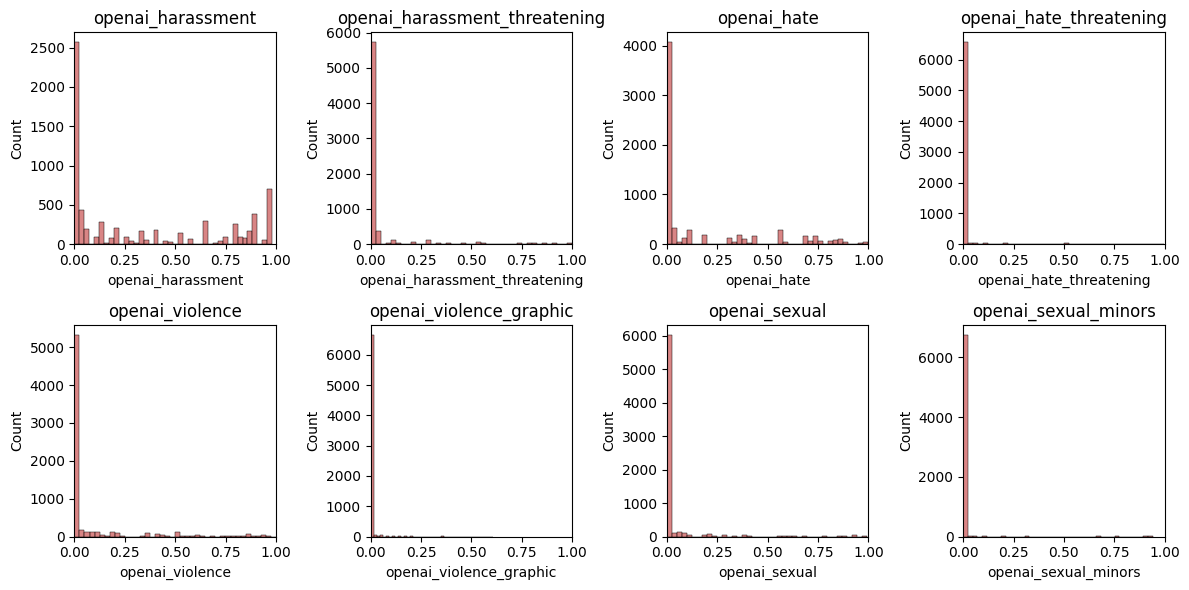

In [64]:
## Distributions: OpenAI category scores
openai_fields = ['openai_harassment','openai_harassment_threatening','openai_hate','openai_hate_threatening','openai_violence','openai_violence_graphic','openai_sexual','openai_sexual_minors']
fig, axes = plt.subplots(2,4, figsize=(12,6))
for ax, col in zip(axes.flat, openai_fields):
    sns.histplot(df[col], bins=40, kde=False, ax=ax, color='indianred')
    ax.set_title(col)
    ax.set_xlim(0,1)
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','openai_distributions.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)


#### Explanation: OpenAI category score distributions
- What it shows: The shape of each OpenAI category’s score distribution.
- How to read: Skew toward 0 indicates rarity; broader or right-shifted distributions indicate more prevalent or stronger signals.
- Cross-API view: Compare to the analogous Google plot to see which categories appear more active across systems.


In [65]:
# Category-wise prevalence and summary stats computed directly from df (no None values)
import numpy as np

google_cols = [
    'google_identity_attack',
    'google_insult',
    'google_profanity',
    'google_severe_toxicity',
    'google_threat',
    'google_toxicity',
]

openai_cols = [
    'openai_harassment',
    'openai_harassment_threatening',
    'openai_hate',
    'openai_hate_threatening',
    'openai_sexual',
    'openai_sexual_minors',
    'openai_violence',
    'openai_violence_graphic',
]

rows = []

def summarize(series: pd.Series):
    s = pd.to_numeric(series, errors='coerce')
    n = int(s.notna().sum())
    mean = float(s.mean()) if n else 0.0
    median = float(s.median()) if n else 0.0
    p90 = float(np.nanpercentile(s, 90)) if n else 0.0
    prev_05 = float((s >= 0.5).mean()) if n else 0.0
    prev_08 = float((s >= 0.8).mean()) if n else 0.0
    return n, mean, median, p90, prev_05, prev_08

for col in google_cols:
    n, mean, median, p90, prev_05, prev_08 = summarize(df[col])
    rows.append({
        'api': 'google',
        'category': col,
        'n': n,
        'mean': round(mean, 4),
        'median': round(median, 4),
        'p90': round(p90, 4),
        'prevalence_ge_0_5': round(prev_05, 6),
        'prevalence_ge_0_8': round(prev_08, 6),
    })

for col in openai_cols:
    n, mean, median, p90, prev_05, prev_08 = summarize(df[col])
    rows.append({
        'api': 'openai',
        'category': col,
        'n': n,
        'mean': round(mean, 4),
        'median': round(median, 4),
        'p90': round(p90, 4),
        'prevalence_ge_0_5': round(prev_05, 6),
        'prevalence_ge_0_8': round(prev_08, 6),
    })

cat_summary_df = pd.DataFrame(rows).sort_values(['api','category']).reset_index(drop=True)
cat_summary_df


,api,category,n,mean,median,p90,prevalence_ge_0_5,prevalence_ge_0_8
0,google,google_identity_attack,6843,0.2043,0.0652,0.5796,0.166594,0.011983
1,google,google_insult,6843,0.2309,0.0883,0.6307,0.194651,0.014321
2,google,google_profanity,6843,0.2504,0.1098,0.7086,0.210872,0.053631
3,google,google_severe_toxicity,6843,0.1057,0.0166,0.3537,0.033757,0.000146
4,google,google_threat,6843,0.0683,0.0114,0.2409,0.033611,0.000146
5,google,google_toxicity,6843,0.3406,0.2867,0.7761,0.300307,0.083881
6,openai,openai_harassment,6843,0.3418,0.1425,0.9639,0.346778,0.251644
7,openai,openai_harassment_threatening,6843,0.0511,0.0009,0.1135,0.042671,0.016805
8,openai,openai_hate,6843,0.1762,0.0081,0.6989,0.172001,0.055239
9,openai,openai_hate_threatening,6843,0.0126,0.0000,0.0045,0.012275,0.004092


#### Explanation: Category-wise prevalence table
- What it shows: For each API/category, the number of posts, mean/median/p90 scores, and the share of posts with scores ≥0.5 and ≥0.8.
- Why we did this: To quantify how common strong signals are by category and compare prevalence across APIs.
- How to use: Report prevalence and summary stats in the write-up; contrast Google vs OpenAI for conceptually similar categories to discuss sensitivity differences.


## Statistical significance testing and confidence intervals

This section adds inferential context:
- Nonparametric significance tests (Mann–Whitney U) comparing mapped Google vs OpenAI category score distributions, with FDR control.
- Bootstrap 95% confidence intervals for Spearman correlations of mapped pairs.
- Bootstrap 95% confidence intervals for category prevalence at thresholds (0.5, 0.8).


In [51]:
# Bootstrap CIs for Spearman correlations (mapped pairs)
import numpy as np
from scipy.stats import spearmanr

mapped_pairs = [
    ('google_toxicity','openai_harassment'),
    ('google_identity_attack','openai_hate'),
    ('google_threat','openai_violence'),
    ('google_profanity','openai_sexual'),
]

rng = np.random.default_rng(42)
B = 1000
ci_results = []
for g,o in mapped_pairs:
    x = pd.to_numeric(df[g], errors='coerce').astype(float).values
    y = pd.to_numeric(df[o], errors='coerce').astype(float).values
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    r_obs, _ = spearmanr(x, y)
    boots = []
    n = len(x)
    for _ in range(B):
        idx = rng.integers(0, n, size=n)
        r_b, _ = spearmanr(x[idx], y[idx])
        boots.append(r_b)
    lo, hi = np.nanpercentile(boots, [2.5, 97.5])
    ci_results.append({'pair': f'{g}__{o}', 'n': n, 'r_obs': float(r_obs), 'ci95': [float(lo), float(hi)]})

ci_df = pd.DataFrame(ci_results)
print(ci_df)

# Save
out_path = os.path.abspath(os.path.join('..','reports','metrics','correlations_cis.json'))
with open(out_path, 'w') as f:
    json.dump({'spearman_cis': ci_results}, f, indent=2)
print('Saved:', out_path)


                                  pair     n     r_obs  \
0   google_toxicity__openai_harassment  6843  0.829809   
1  google_identity_attack__openai_hate  6843  0.871037   
2       google_threat__openai_violence  6843  0.640183   
3      google_profanity__openai_sexual  6843  0.425488   

                                        ci95  
0   [0.8220526387840204, 0.8377908349280556]  
1   [0.8648053861666462, 0.8768465407687899]  
2   [0.6229257368675579, 0.6558007823110372]  
3  [0.4033190868307414, 0.44596916605763093]  
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/metrics/correlations_cis.json


In [52]:
# Mann–Whitney U tests for mapped pairs (distributional differences) with FDR control
from scipy.stats import mannwhitneyu

def fdr_bh(pvals, alpha=0.05):
    m = len(pvals)
    idx = np.argsort(pvals)
    sorted_p = np.array(pvals)[idx]
    thresh = (np.arange(1, m+1) / m) * alpha
    passed = sorted_p <= thresh
    crit = None
    if passed.any():
        k = np.max(np.where(passed)[0])
        crit = thresh[k]
    rejected = np.zeros(m, dtype=bool)
    if crit is not None:
        rejected = sorted_p <= crit
    # restore original order
    restore = np.empty(m, dtype=int)
    restore[idx] = np.arange(m)
    return rejected[restore], crit

mw_rows = []
for g,o in mapped_pairs:
    x = pd.to_numeric(df[g], errors='coerce').dropna().values
    y = pd.to_numeric(df[o], errors='coerce').dropna().values
    # two-sided Mann–Whitney
    stat, p = mannwhitneyu(x, y, alternative='two-sided')
    mw_rows.append({'pair': f'{g}__{o}', 'n_g': len(x), 'n_o': len(y), 'u_stat': float(stat), 'p_value': float(p)})

mw_df = pd.DataFrame(mw_rows)
rej, crit = fdr_bh(mw_df['p_value'].tolist(), alpha=0.05)
mw_df['fdr_reject'] = rej
mw_df['fdr_crit'] = crit
print(mw_df)

out_path = os.path.abspath(os.path.join('..','reports','metrics','mannwhitney_fdr.json'))
with open(out_path, 'w') as f:
    json.dump({'tests': mw_rows, 'fdr': {'alpha': 0.05, 'reject_mask': rej.tolist(), 'crit': crit}}, f, indent=2)
print('Saved:', out_path)


                                  pair   n_g   n_o      u_stat        p_value  \
0   google_toxicity__openai_harassment  6843  6843  26863608.0   2.118733e-50   
1  google_identity_attack__openai_hate  6843  6843  29093090.0  2.249577e-133   
2       google_threat__openai_violence  6843  6843  32504357.0   0.000000e+00   
3      google_profanity__openai_sexual  6843  6843  43131171.0   0.000000e+00   

   fdr_reject  fdr_crit  
0        True      0.05  
1        True      0.05  
2        True      0.05  
3        True      0.05  
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/metrics/mannwhitney_fdr.json


In [53]:
# Bootstrap CIs for prevalence (>=0.5 and >=0.8) per category
rng = np.random.default_rng(123)
B = 1000
prev_rows = []

for api, cols in [('google', google_cols), ('openai', openai_cols)]:
    for col in cols:
        s = pd.to_numeric(df[col], errors='coerce').dropna().values
        n = len(s)
        if n == 0:
            continue
        for thr in [0.5, 0.8]:
            p_obs = float((s >= thr).mean())
            boots = []
            for _ in range(B):
                idx = rng.integers(0, n, size=n)
                boots.append(float((s[idx] >= thr).mean()))
            lo, hi = np.nanpercentile(boots, [2.5, 97.5])
            prev_rows.append({
                'api': api,
                'category': col,
                'threshold': thr,
                'n': n,
                'p_obs': p_obs,
                'ci95': [float(lo), float(hi)]
            })

prev_df = pd.DataFrame(prev_rows)
print(prev_df.head())

out_path = os.path.abspath(os.path.join('..','reports','metrics','prevalence_cis.json'))
with open(out_path, 'w') as f:
    json.dump({'prevalence_cis': prev_rows}, f, indent=2)
print('Saved:', out_path)


      api                category  threshold     n     p_obs  \
0  google  google_identity_attack        0.5  6843  0.166594   
1  google  google_identity_attack        0.8  6843  0.011983   
2  google           google_insult        0.5  6843  0.194651   
3  google           google_insult        0.8  6843  0.014321   
4  google        google_profanity        0.5  6843  0.210872   

                                           ci95  
0     [0.1581177845973988, 0.17536168347216133]  
1   [0.009352623118515271, 0.01461347362268011]  
2    [0.18514540406254565, 0.20400774514102002]  
3  [0.011544644161917288, 0.017101417506941396]  
4    [0.20049320473476545, 0.22095937454332895]  
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/metrics/prevalence_cis.json


#### Explanation: Significance tests and confidence intervals
- Correlation CIs: Quantify uncertainty around Spearman r for mapped pairs (robust to non-normality).
- Mann–Whitney + FDR: Tests whether Google vs OpenAI score distributions differ; FDR controls false discoveries across multiple pairs.
- Prevalence CIs: Show uncertainty around the share of high-score posts, useful for comparing categories/APIs.
- Reporting: Use these intervals and adjusted p-values to support claims in the Results section.


## Highest disagreement by content type (mapped categories)

We quantify disagreement (mismatch rate) per mapped Google–OpenAI category pair at a fixed Google threshold (default 0.8) versus `openai_flagged`. This ranks “content types” by where the two systems diverge the most.


                      pair             google_attr        openai_attr     n  \
0       threat vs violence           google_threat    openai_violence  6843   
1  identity_attack vs hate  google_identity_attack        openai_hate  6843   
2      profanity vs sexual        google_profanity      openai_sexual  6843   
3   toxicity vs harassment         google_toxicity  openai_harassment  6843   

   mismatch_rate  
0       0.436358  
1       0.424521  
2       0.397194  
3       0.357884  


Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/mismatch_by_category.png
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/metrics/mismatch_by_category.json


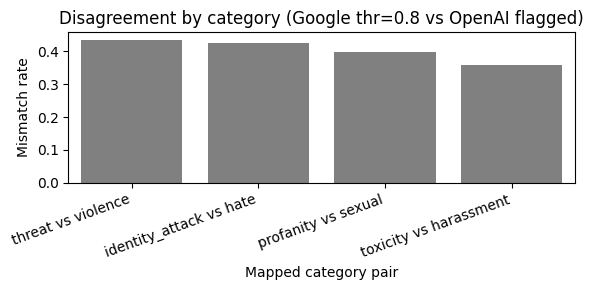

In [66]:
# Compute per-category mismatch rates and rank
pairs = [
    ('google_toxicity','openai_harassment','toxicity vs harassment'),
    ('google_identity_attack','openai_hate','identity_attack vs hate'),
    ('google_threat','openai_violence','threat vs violence'),
    ('google_profanity','openai_sexual','profanity vs sexual'),
]

G_THR = 0.8
rows = []
for g,o,label in pairs:
    true_labels = (pd.to_numeric(df[g], errors='coerce') >= G_THR).astype('Int64')
    pred_labels = df['openai_flagged'].astype('Int64')
    mask = true_labels.notna() & pred_labels.notna()
    tl = true_labels[mask].astype(int)
    pl = pred_labels[mask].astype(int)
    n = len(tl)
    mismatches = int(((tl == 1) & (pl == 0)).sum() + ((tl == 0) & (pl == 1)).sum())
    mismatch_rate = mismatches / n if n else 0.0
    rows.append({'pair': label, 'google_attr': g, 'openai_attr': o, 'n': n, 'mismatch_rate': mismatch_rate})

mis_df = pd.DataFrame(rows).sort_values('mismatch_rate', ascending=False).reset_index(drop=True)
print(mis_df)

# Plot
plt.figure(figsize=(6,3))
sns.barplot(x='pair', y='mismatch_rate', data=mis_df, color='gray')
plt.ylabel('Mismatch rate')
plt.xlabel('Mapped category pair')
plt.title(f'Disagreement by category (Google thr={G_THR} vs OpenAI flagged)')
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','mismatch_by_category.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)

# Save metrics
out_path = os.path.abspath(os.path.join('..','reports','metrics','mismatch_by_category.json'))
with open(out_path,'w') as f:
    json.dump({'google_threshold': G_THR, 'rows': rows}, f, indent=2)
print('Saved:', out_path)


#### Explanation: Highest disagreement by content type
- What it shows: The mismatch rate per mapped category pair at a fixed Google threshold vs OpenAI flagged.
- How to read: Higher bars mean more frequent disagreement for that content type.
- Why it matters: Pinpoints categories where systems diverge most, guiding threshold choices or qualitative review.
- Tip: You can change `G_THR` in the cell above to test robustness at other thresholds (e.g., 0.7, 0.9).


## Which API demonstrates greater sensitivity to different toxic content categories?

Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/openai_flagged_rate_across_google_toxicity_deciles.png
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/openai_flagged_rate_across_google_identity_attack_deciles.png


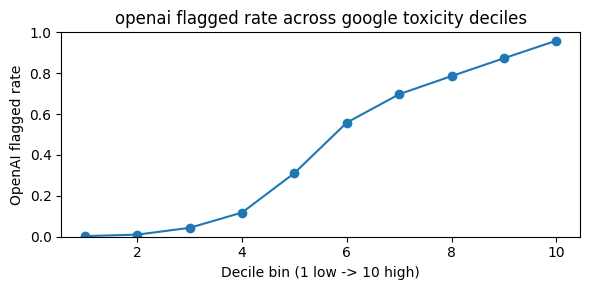

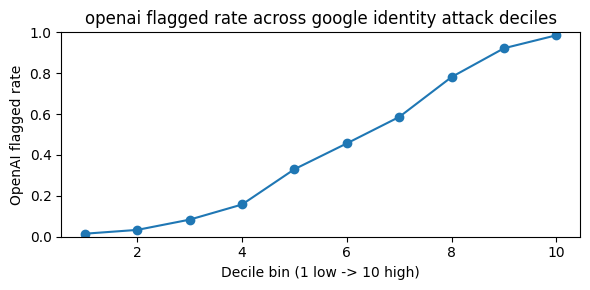

In [54]:
## Sensitivity curves
import json
SENS_PATH = os.path.abspath(os.path.join('..','reports','metrics','sensitivity_summary.json'))
with open(SENS_PATH,'r') as f:
    sens = json.load(f)

for key in [
    'openai_flagged_rate_across_google_toxicity_deciles',
    'openai_flagged_rate_across_google_identity_attack_deciles',
]:
    data = sens[key]
    xs = [d['bin'] for d in data]
    ys = [d['positive_rate'] for d in data]
    plt.figure(figsize=(6,3))
    plt.plot(xs, ys, marker='o')
    plt.ylim(0,1)
    plt.xlabel('Decile bin (1 low -> 10 high)')
    plt.ylabel('OpenAI flagged rate')
    plt.title(key.replace('_',' '))
    fig_path = os.path.abspath(os.path.join('..','reports','figures',f'{key}.png'))
    plt.tight_layout(); plt.savefig(fig_path, dpi=200)
    print('Saved:', fig_path)


#### Explanation: Sensitivity curves
- What it shows: How OpenAI’s positive rate changes across deciles of a Google score (e.g., toxicity, identity attack).
- How to read: If the line rises from decile 1→10, OpenAI becomes more likely to flag as Google’s score increases (stronger alignment/sensitivity). A flat line suggests weak sensitivity.
- Why it matters: Lets us compare relative sensitivity between APIs and categories without locking into a single threshold.
- What to report: Positive rate in bottom vs top deciles and whether the curve is monotonic/steep; compare categories.


In [58]:
# Bottom vs top decile deltas for sensitivity curves (one-line takeaways)
import json
SENS_PATH = os.path.abspath(os.path.join('..','reports','metrics','sensitivity_summary.json'))
with open(SENS_PATH,'r') as f:
    sens = json.load(f)

keys = [
    'openai_flagged_rate_across_google_toxicity_deciles',
    'openai_flagged_rate_across_google_identity_attack_deciles',
]

def bottom_top_delta(entries):
    # entries expected sorted by 'bin' from 1..10
    entries = sorted(entries, key=lambda d: d['bin'])
    bottom = float(entries[0]['positive_rate'])
    top = float(entries[-1]['positive_rate'])
    return bottom, top, top - bottom

rows = []
for k in keys:
    if k in sens:
        b, t, d = bottom_top_delta(sens[k])
        rows.append({'curve': k, 'bottom_decile_rate': round(b,4), 'top_decile_rate': round(t,4), 'delta_top_minus_bottom': round(d,4)})

import pandas as pd
sens_delta_df = pd.DataFrame(rows)
print(sens_delta_df)
sens_delta_df


                                               curve  bottom_decile_rate  \
0  openai_flagged_rate_across_google_toxicity_dec...              0.0029   
1  openai_flagged_rate_across_google_identity_att...              0.0147   

   top_decile_rate  delta_top_minus_bottom  
0           0.9592                  0.9563  
1           0.9857                  0.9709  


,curve,bottom_decile_rate,top_decile_rate,delta_top_minus_bottom
0,openai_flagged_rate_across_google_toxicity_dec...,0.0029,0.9592,0.9563
1,openai_flagged_rate_across_google_identity_att...,0.0147,0.9857,0.9709


## Temporal and length trends
- What it shows:
  - Hourly mean toxicity: average Google toxicity across UTC hours to see diurnal patterns.
  - Mean toxicity by content length bin: whether longer/shorter posts correlate with higher mean toxicity.
- How to read:
  - Line plot (hourly): rising sections indicate hours with higher average toxicity.
  - Bar plot (length bins): taller bars indicate higher mean toxicity for that bin.
- Why it matters: Contextualizes toxicity dynamics over time and by post size, which can inform sampling, threshold setting, and interpreting disagreement patterns.


Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/hourly_mean_toxicity.png
Saved: /Users/monk/Desktop/Projects/research/4chan-toxicity-analysis/reports/figures/length_bin_mean_toxicity.png


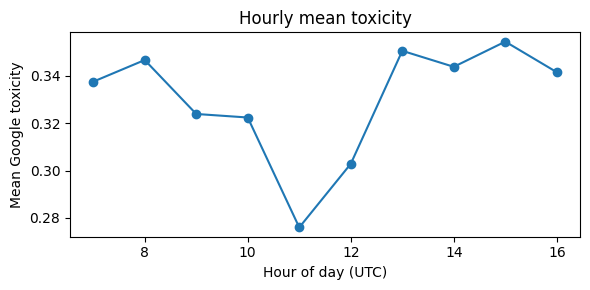

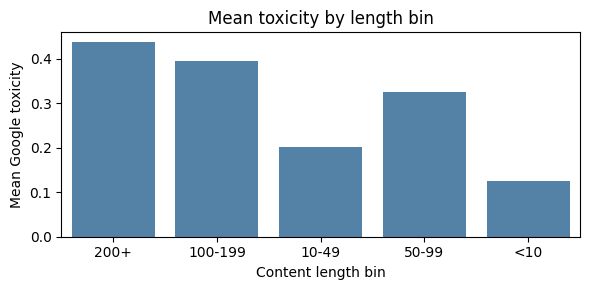

In [57]:
## Temporal and length trends visualization
import json
TL_PATH = os.path.abspath(os.path.join('..','reports','metrics','temporal_length_summary.json'))
with open(TL_PATH,'r') as f:
    tls = json.load(f)

# Hourly mean toxicity
hrs = sorted((int(h), v['mean_google_toxicity']) for h,v in tls['by_hour_mean_toxicity'].items())
plt.figure(figsize=(6,3))
plt.plot([h for h,_ in hrs], [v for _,v in hrs], marker='o')
plt.xlabel('Hour of day (UTC)')
plt.ylabel('Mean Google toxicity')
plt.title('Hourly mean toxicity')
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','hourly_mean_toxicity.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)

# Length-bin mean toxicity
lb = tls['by_length_bin_mean_toxicity']
keys = list(lb.keys())
vals = [lb[k]['mean_google_toxicity'] for k in keys]
plt.figure(figsize=(6,3))
sns.barplot(x=keys, y=vals, color='steelblue')
plt.xlabel('Content length bin')
plt.ylabel('Mean Google toxicity')
plt.title('Mean toxicity by length bin')
plt.tight_layout()
fig_path = os.path.abspath(os.path.join('..','reports','figures','length_bin_mean_toxicity.png'))
plt.savefig(fig_path, dpi=200)
print('Saved:', fig_path)


## Results (concise)
- Correlations (Spearman) between mapped pairs are strong for identity_attack↔hate and moderate for threat↔violence; see `reports/figures/correlation_heatmap.png` and CIs in `reports/metrics/correlations_cis.json`.

- Agreement: Confusion matrix at Google thr=0.8 vs `openai_flagged` plus segment mismatch plots; see `cm_toxicity_vs_openai_flagged.png`, `disagreement_by_length.png`, `disagreement_by_position.png`.

- Category distributions: Skewed toward low scores with heavier tails in certain categories; see `google_distributions.png`, `openai_distributions.png`; numerical table in notebook `cat_summary_df`.

- Sensitivity: OpenAI flagged rate increases across Google deciles, with category-specific steepness; see sensitivity plots and bottom-vs-top decile deltas table.
- Highest disagreement by category: Ranked mismatch rates identify where systems diverge most; see `mismatch_by_category.png` and `reports/metrics/mismatch_by_category.json`.

- FP/FN patterns: Directional summaries highlight stricter/looser tendencies and typical characteristics; see printed outputs and `fp_fn_summary.json`.


## Methods (brief)
- Cohort: Posts where both APIs succeeded from `src/data/analysis_dataset.jsonl`.

- Mappings: {toxicity↔harassment, identity_attack↔hate, threat↔violence, profanity↔sexual}.

- Thresholding: Google positives defined at score ≥0.8 for binary agreement; robustness can be checked by adjusting `G_THR`.

- Statistics: Spearman correlations; Mann–Whitney U with FDR; bootstrap CIs for correlations and prevalence.

- Segmentation: Disagreement summarized by content length bins and thread position.

- Reproducibility: All figures saved to `reports/figures/`, metrics to `reports/metrics/`.


## Limitations (brief)
- Category mapping is approximate (e.g., profanity↔sexual), which can affect alignment.

- Threshold choice (0.8) influences binary agreement; sensitivity checked via curves and adjustable `G_THR`.

- Short posts and multilingual content may behave differently; cohort restricts to successful API responses.

- No human labels: agreement is cross-system, not ground-truth validation; FP/FN-like analyses are directional.

- Multiple comparisons: addressed by FDR for tests, but practical significance remains key.
